# Initialization

## Mount to drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/My\ Drive/VUB/Thesis

/content/drive/My Drive/VUB/Thesis


## Install dependencies

In [3]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import Libraries

In [4]:
import sys
import array
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib.cm import ScalarMappable
import json
import gc
import os

os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"
os.environ['DISPLAY']="0.0"
import cv2
import open3d as o3d

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

from torchmetrics.functional import peak_signal_noise_ratio, structural_similarity_index_measure, mean_squared_error

import OpenEXR
import Imath
from kornia.contrib.extract_patches import extract_tensor_patches, combine_tensor_patches
%env PYTORCH_CUDA_ALLOC_CONF=garbage_collection_threshold:0.6,max_split_size_mb:128

env: PYTORCH_CUDA_ALLOC_CONF=garbage_collection_threshold:0.6,max_split_size_mb:128


# Constants

In [5]:
DATA_ROOT_DIR_NAME = "./data"

TRAIN_DIR_NAME = DATA_ROOT_DIR_NAME + "/train"
VALID_DIR_NAME = DATA_ROOT_DIR_NAME + "/valid"
TEST_DIR_NAME = DATA_ROOT_DIR_NAME + "/test"

CLEAN_DIR_NAME =  "/clean"
NOISY_DIR_NAME = "/noisy"
INFO_DIR_NAME = "/info"

EXR_REGEX = "/depth_S{:06d}_C{:02d}.exr"
JSON_REGEX = "/info_S{:06d}_C{:02d}.json"

INTRINSIC = "intrinsic"
EXTRINSIC = "extrinsic"

CACHE_DIR_NAME = DATA_ROOT_DIR_NAME + "/cache"
TRAIN_CACHE_CLEAN = CACHE_DIR_NAME + "/train_clean.pickle"
VALID_CACHE_CLEAN = CACHE_DIR_NAME + "/valid_clean.pickle"
TEST_CACHE_CLEAN = CACHE_DIR_NAME + "/test_clean.pickle"
TRAIN_CACHE_NOISY = CACHE_DIR_NAME + "/train_noisy.pickle"
VALID_CACHE_NOISY = CACHE_DIR_NAME + "/valid_noisy.pickle"
TEST_CACHE_NOISY = CACHE_DIR_NAME + "/test_noisy.pickle"

TENSORBOARD = SummaryWriter()

SAVE_MODEL_NAME = 'unet_denoiser_model.pth'
SEGMENTATION_MODEL_NAME = 'segmentation_model.pth'

NO_CAMERAS = 3
NO_SAMPLES = 1500
TRAIN_SAMPLES = int(0.6 * NO_SAMPLES * NO_CAMERAS) // 3
VALID_SAMPLES = int(0.2 * NO_SAMPLES * NO_CAMERAS) // 3
TEST_SAMPLES = int(0.2 * NO_SAMPLES * NO_CAMERAS) // 3

PATCH_SIZE = 64
STRIDE = PATCH_SIZE // 2
PADDING = 0
VALID_PIXELS_PERCENTAGE = 0.7
VALID_PATCH_THRESHOLD = (PATCH_SIZE * PATCH_SIZE) * VALID_PIXELS_PERCENTAGE
BATCH_SIZE = 128

# Data Gathering and Pre-Processing

## Pre-process data

In [6]:
# B = Batch size
# N = number of patches
# C = channels
# H = height
# W = width

def read_depth_image(file_path: str, scene: int, camera_no: int, clean:bool=True):
    # returns a tensor (C x H x W)
    depth_regex = file_path + CLEAN_DIR_NAME + EXR_REGEX if clean else file_path + NOISY_DIR_NAME + EXR_REGEX
    exr_file_name = depth_regex.format(scene, camera_no)
    depth = cv2.imread(exr_file_name, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
    return T.ToTensor()(depth)

def extract_samples(file_path: str, dataset: str, clean=True, start_range=None, end_range=None):
    samples = list()
    if start_range is None:
      start_range = 0 if dataset == 'train' else TRAIN_SAMPLES if dataset == 'valid' else TRAIN_SAMPLES + VALID_SAMPLES
    if end_range is None:
      end_range = TRAIN_SAMPLES if dataset == 'train' else TRAIN_SAMPLES + VALID_SAMPLES if dataset == 'valid' else NO_SAMPLES
    for scene in range(start_range, end_range):
        for camera in range(NO_CAMERAS):
            # Read each sample
            # (1024 x 1024) depth map size
            sample = read_depth_image(file_path, scene, camera, clean)
            # Add to final list
            samples.append(sample)
    return samples

def extract_valid_patches(patches):
    # patches = tensor (N x H x W)
    no_patches = patches.shape[0]
    valid_patches = list()
    for idx in range(no_patches):
        patch = patches[idx,:]
        if torch.count_nonzero(patch) > VALID_PATCH_THRESHOLD:
            valid_patches.append(patch)
    return valid_patches

def normalize_patch(patch):
    # patches = tensor (H x W)
    mask = patch > 0  # mask to only consider valid depth values
    valid_idx = torch.nonzero(patch)
    valid_values = patch[valid_idx[:,0], valid_idx[:,1]]
    std, mean = torch.std_mean(valid_values)
    eps = torch.tensor(1e-5)
    scale = torch.max(std, eps)
    patch = torch.where(patch > 0, (patch-mean)/scale, 0)
    return patch, scale

def normalize_patches(patches):
    # patches = tensor (N x H x W)
    normalized_patches = list()
    for patch in patches:
        normalized_patch = normalize_patch(patch)
        normalized_patches.append(normalized_patch)
    return normalized_patches

def extract_patches_from_sample(depth, stride=STRIDE, only_valid=True):
    # depth = tensor (C x H x W)
    # Split the depth map into patches
    depth = depth.unsqueeze(0) # add a dimention for B => (B x C x H x W)
    patches = extract_tensor_patches(depth, PATCH_SIZE, stride, PADDING) # (B x N x C x H x W)
    patches = patches.squeeze(2) # remove channels
    patches = patches.squeeze(0) # remove batch size => (N x H x W)
    if only_valid:
        patches = extract_valid_patches(patches)
    return patches

def extract_patches(samples):
    final_patches = list()
    for sample in tqdm(samples):
        patches = extract_patches_from_sample(sample)
        final_patches.extend(patches)
    return final_patches

def compare_patches(patch, patch_nosisy):
    # Convert the depth map tensor to a NumPy array
    depth_map_np = patch.numpy()
    depth_map_np_n = patch_nosisy.numpy()

    # Display the depth map using Matplotlib
    f, axarr = plt.subplots(1, 2, figsize=(10,10))
    axarr[0].imshow(depth_map_np, cmap='inferno')
    axarr[1].imshow(depth_map_np_n, cmap='inferno')
    scales = np.linspace(0, 1, 2)
    cmap = plt.get_cmap("inferno")
    norm = plt.Normalize(scales.min(), scales.max())
    sm =  ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = f.colorbar(sm, ax=axarr)
    cbar.ax.set_title("scale")    

def compare_patches_3(patch1, patch2, patch3):
    # Convert the depth map tensor to a NumPy array
    patch1_np = patch1.numpy()
    patch2_np = patch2.numpy()
    patch3_np = patch3.numpy()

    # Display the depth map using Matplotlib
    f, axarr = plt.subplots(1, 3, figsize=(10,10))
    axarr[0].imshow(patch1_np, cmap='inferno')
    axarr[0].set_title('Clean')
    axarr[1].imshow(patch2_np, cmap='inferno')
    axarr[1].set_title('Predicted')
    axarr[2].imshow(patch3_np, cmap='inferno')
    axarr[2].set_title('Noisy')

## Define dataset

In [7]:
class DepthMapDataset(Dataset):
    def __init__(self, file_path, dataset, start, end, use_cache):
        self.clean_data = self.extract_data(file_path, dataset, True, start, end, use_cache)
        self.noisy_data = self.extract_data(file_path, dataset, False, start, end, use_cache)
    
    def extract_data(self, file_path, dataset, clean:bool, start=None, end=None, use_cache=True):
        clean_noisy = 'clean' if clean else 'noisy'
        if use_cache:
            data = self.get_cached_files(dataset, clean)
            if data is not None:
                print(f"Found cached files for {clean_noisy} {dataset} dataset with {len(data)} elements.")
                return data
        samples = extract_samples(file_path, dataset, clean, start, end)
        patches = extract_patches(samples)
        if use_cache:
            self.cache_files(dataset, patches, clean)
            print(f"Cached files for {clean_noisy} {dataset} dataset with {len(patches)} elements.")
        else:
            print(f"Created files for {clean_noisy} {dataset} dataset with {len(patches)} elements.")
        return patches

    def cache_files(self, dataset, data, clean):
        if dataset == 'train':
            if clean:
                torch.save(data, TRAIN_CACHE_CLEAN)
            else:
                torch.save(data, TRAIN_CACHE_NOISY)
        elif dataset == 'valid':
            if clean:
                torch.save(data, VALID_CACHE_CLEAN)
            else:
                torch.save(data, VALID_CACHE_NOISY)
        elif dataset == 'test':
            if clean:
                torch.save(data, TEST_CACHE_CLEAN)
            else:
                torch.save(data, TEST_CACHE_NOISY)

    def get_cached_files(self, dataset, clean):
        data = None
        if dataset == 'train' and clean:
            data = torch.load(TRAIN_CACHE_CLEAN) if os.path.exists(TRAIN_CACHE_CLEAN) else None
        elif dataset == 'train' and not clean:
            data = torch.load(TRAIN_CACHE_NOISY) if os.path.exists(TRAIN_CACHE_NOISY) else None
        elif dataset == 'valid' and clean:
            data = torch.load(VALID_CACHE_CLEAN) if os.path.exists(VALID_CACHE_CLEAN) else None
        elif dataset == 'valid' and not clean:
            data = torch.load(VALID_CACHE_NOISY) if os.path.exists(VALID_CACHE_NOISY) else None
        elif dataset == 'test' and clean:
            data = torch.load(TEST_CACHE_CLEAN) if os.path.exists(TEST_CACHE_CLEAN) else None
        elif dataset == 'test' and not clean:
            data = torch.load(TEST_CACHE_NOISY) if os.path.exists(TEST_CACHE_NOISY) else None
        return data
        
    def __len__(self):
        return len(self.clean_data)
    
    def __getitem__(self, index):
        clean_patch = self.clean_data[index]
        noisy_patch = self.noisy_data[index]
        return clean_patch, noisy_patch

In [8]:
def get_loader(file_path=TRAIN_DIR_NAME, dataset='train', start=0, end=100, use_cache=True, batch_size=32, num_workers=4, shuffle=False, pin_memory=True):
    dataset = DepthMapDataset(file_path, dataset, start, end, use_cache)
    loader = DataLoader(
        dataset=dataset, 
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle, 
        pin_memory=pin_memory)
    
    return loader, dataset

In [9]:
train_loader, train_dataset = get_loader(file_path=TRAIN_DIR_NAME,
                                         dataset='train',
                                         start=0,
                                         end=200,
                                         use_cache=True,
                                         batch_size=BATCH_SIZE, 
                                         shuffle=True)
valid_loader, valid_dataset = get_loader(file_path=VALID_DIR_NAME,
                                         dataset='valid',
                                         start=900,
                                         end=950,
                                         use_cache=True,
                                         batch_size=BATCH_SIZE, 
                                         shuffle=True)
test_loader, test_dataset = get_loader(file_path=TEST_DIR_NAME,
                                       dataset='test',
                                       start=1200,
                                       end=1210,
                                       use_cache=True,
                                       batch_size=BATCH_SIZE, 
                                       shuffle=False)

Found cached files for clean train dataset with 76948 elements.
Found cached files for noisy train dataset with 76948 elements.
Found cached files for clean valid dataset with 19543 elements.
Found cached files for noisy valid dataset with 19543 elements.
Found cached files for clean test dataset with 4034 elements.
Found cached files for noisy test dataset with 4034 elements.


### Display a patch

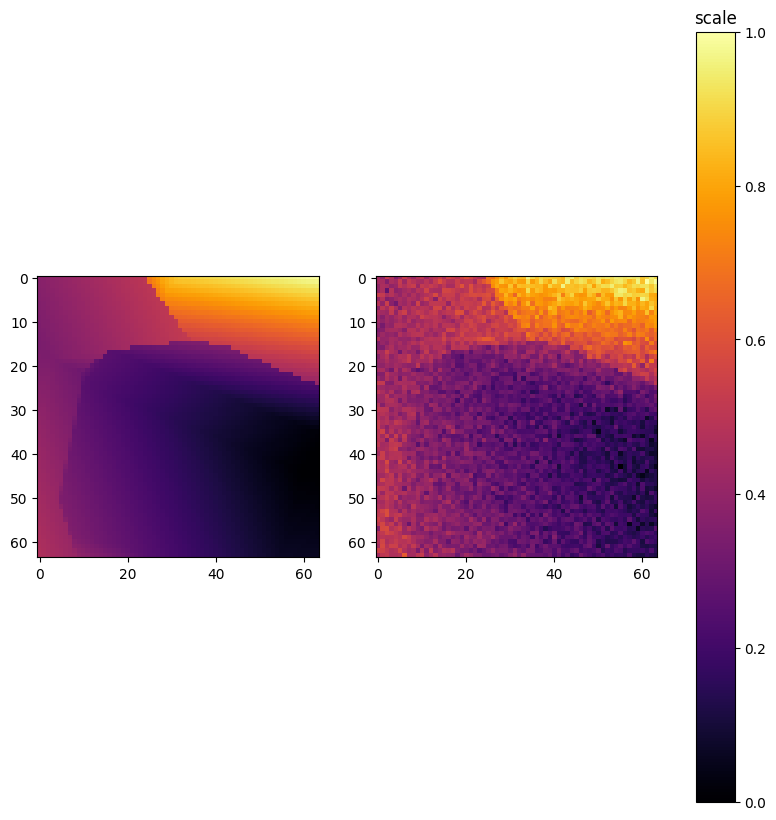

In [ ]:
# Extract a clean & a noisy patch
RANDOM_SAMPLE_ID = 21
depth_map = test_dataset.clean_data[RANDOM_SAMPLE_ID]
depth_map_n = test_dataset.noisy_data[RANDOM_SAMPLE_ID]

compare_patches(depth_map, depth_map_n)

# Model

## Hyperparameters

In [ ]:
LEARNING_RATE = 8e-4
EPOCHS = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Helper functions

In [11]:
def print_depth_map(depth):
    depth_np = depth.numpy()
    plt.imshow(depth_np, cmap="inferno")
    plt.colorbar()
    plt.show()

def separate_depth(depth):
    min_val = torch.min(depth[depth>0]).item()
    max_val = torch.max(depth).item()
    no_valid_pixels = torch.sum(depth[depth>0])
    mask = depth > 0

    bins = 3

    hist = torch.histogram(depth, bins=bins, range=(min_val, max_val))
    hist_qty = hist[0]
    hist_bin_edges = hist[1]

    # Print histogram
    x = range(bins)
    plt.bar(x, hist_qty, align='center', color=['forestgreen'])
    plt.xlabel('Bins')
    plt.ylabel('Frequency')
    plt.show()

    should_separate = (torch.max(hist_qty) < no_valid_pixels * 0.75).item()

    if should_separate:
        mask_idx = torch.argmax(hist_qty)
        depth_new = depth.squeeze(0)
        extracted_mask = (depth_new > hist_bin_edges[mask_idx].item()) * (depth_new < hist_bin_edges[mask_idx+1].item())
        extracted = extracted_mask * depth_new
        remainder_mask = (depth_new > 0) * (~extracted_mask)
        remainder = remainder_mask * depth_new
        extracted = extracted.unsqueeze(0)
        remainder = remainder.unsqueeze(0)
        extracted_mask = extracted_mask.unsqueeze(0)
        return torch.where(extracted_mask == True, 1.0, 0.0)
    else:
        return torch.where(depth > 0, 1.0, 0.0)

def separate_depth_for_batch(depth_batch):
    separated_patches = list()
    for patch in depth_batch:
        separate_patches = separate_depth(patch)
        separate_patches = separate_patches.unsqueeze(0)
        separated_patches.append(separate_patches)
    return torch.cat(separated_patches, 0)

## Model Architecture

In [ ]:
class SegmentationAutoencoder(nn.Module):
    def __init__(self, input_channels):
        super(SegmentationAutoencoder, self).__init__()

        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv4 = nn.ConvTranspose2d(64, 16, kernel_size=3, stride=2, padding=1, output_padding=1)

        # Output layer
        self.out = nn.Conv2d(16, input_channels, kernel_size=1)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))

        out = self.out(x)
        out = F.sigmoid(out)
        return out

# Training

In [ ]:
gc.collect()
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)

print("Running on device ", device)

# Define the segmentation autoencoder model and optimizer
model = SegmentationAutoencoder(1).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Define the loss function
criterion = nn.BCELoss()

# Train the denoising autoencoder
for epoch in range(EPOCHS):
    # Training
    train_loss = 0.0
    model.train()
    for idx, data in enumerate(tqdm(train_loader)):
        if idx % 2 == 0:
            _, patches = data
        else:
            patches, _ = data

        # Separate patches
        patches = patches.unsqueeze(1)
        masks_patches = separate_depth_for_batch(patches)

        # Send data to cuda
        if torch.cuda.is_available():
            patches = patches.cuda()
            masks_patches = masks_patches.cuda()

        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(patches)
        
        # Compute the loss
        loss = criterion(output, masks_patches)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        train_loss = train_loss + loss.item()

    # Validation
    gc.collect()
    torch.cuda.empty_cache() 
    valid_loss = 0.0
    model.eval()
    with torch.no_grad():
        for idx, data in enumerate(tqdm(valid_loader)):
            if idx % 2 == 0:
                _, patches = data
            else:
                patches, _ = data

            # Separate patches
            patches = patches.unsqueeze(1)
            masks_patches = separate_depth_for_batch(patches)
            
            # Send data to cuda
            if torch.cuda.is_available():
                patches = patches.cuda()
                masks_patches = masks_patches.cuda()
        
            # Forward pass
            output = model(patches)
        
            # Compute the loss
            loss = criterion(output, masks_patches)

            valid_loss = valid_loss + loss.item()
        
    train_loss = train_loss / len(train_loader)
    valid_loss = valid_loss / len(valid_loader)

    TENSORBOARD.add_scalar("Segmentation Train loss", train_loss, epoch)
    TENSORBOARD.add_scalar("Segmentation Valid loss", valid_loss, epoch)
    print(f"Epoch [{epoch+1}/{EPOCHS}]: Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")
TENSORBOARD.flush()
TENSORBOARD.close()

Running on device  cuda:0


100%|██████████| 153/153 [00:13<00:00, 11.67it/s]


Epoch [1/10]: Train Loss: 0.6148, Valid Loss: 0.6148


100%|██████████| 153/153 [00:13<00:00, 11.57it/s]


Epoch [2/10]: Train Loss: 0.6085, Valid Loss: 0.6144


100%|██████████| 153/153 [00:13<00:00, 11.61it/s]


Epoch [3/10]: Train Loss: 0.6070, Valid Loss: 0.6128


100%|██████████| 153/153 [00:13<00:00, 11.52it/s]


Epoch [4/10]: Train Loss: 0.6063, Valid Loss: 0.6111


100%|██████████| 153/153 [00:13<00:00, 11.61it/s]


Epoch [5/10]: Train Loss: 0.6047, Valid Loss: 0.6108


100%|██████████| 153/153 [00:13<00:00, 11.63it/s]


Epoch [6/10]: Train Loss: 0.6041, Valid Loss: 0.6089


100%|██████████| 153/153 [00:13<00:00, 11.71it/s]


Epoch [7/10]: Train Loss: 0.6027, Valid Loss: 0.6088


100%|██████████| 153/153 [00:13<00:00, 11.72it/s]


Epoch [8/10]: Train Loss: 0.6019, Valid Loss: 0.6081


100%|██████████| 153/153 [00:13<00:00, 11.67it/s]


Epoch [9/10]: Train Loss: 0.6013, Valid Loss: 0.6063


100%|██████████| 153/153 [00:13<00:00, 11.73it/s]

Epoch [10/10]: Train Loss: 0.6005, Valid Loss: 0.6081


# Visualize loss

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir runs

# Evaluation

  0%|          | 0/32 [00:00<?, ?it/s]

Batch 0: MSE: 0.6355


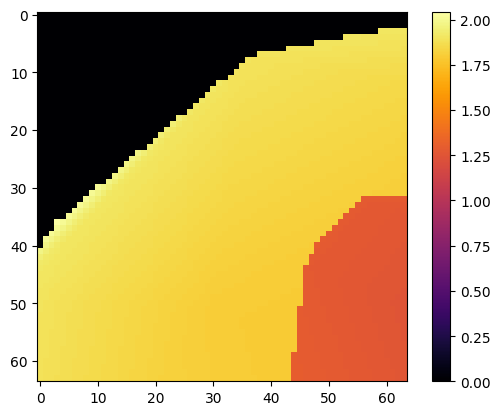

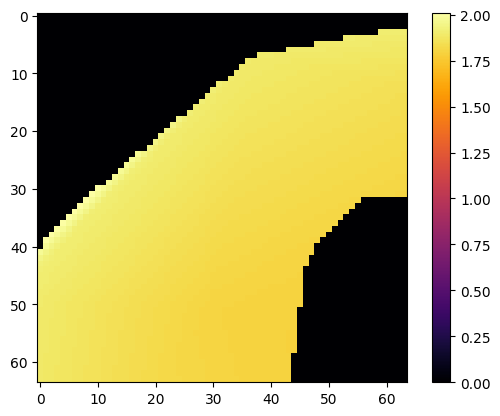

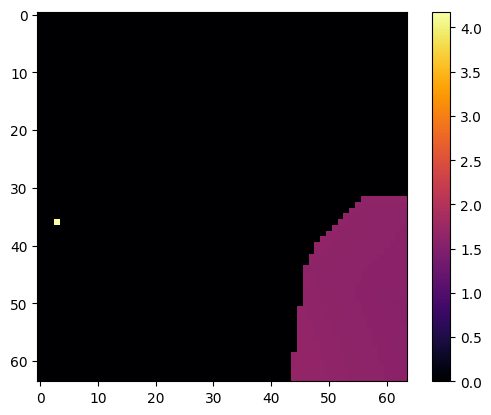

100%|██████████| 32/32 [00:04<00:00,  6.70it/s]

MSE: 0.5853


In [ ]:
torch.cuda.empty_cache()
model.eval()

criterion = nn.BCELoss()
mse_loss = 0.0
for idx, data in enumerate(tqdm(test_loader)):
    if idx % 2 == 1:
        _, patches = data
    else:
        patches, _ = data

    # Separate patches
    patches = patches.unsqueeze(1)
    masks_patches = separate_depth_for_batch(patches)

    # Send data to cuda
    if torch.cuda.is_available():
        patches = patches.cuda()
        masks_patches = masks_patches.cuda()
        
    # Forward pass
    output = model(patches)

    loss = criterion(output, masks_patches)
    mse_loss = mse_loss + loss

    if idx == 0:
        print(f"Batch {idx}: MSE: {loss:.4f}")
        print_depth_map(patches[0].detach().cpu().squeeze(0))
        mask = torch.where(masks_patches[0] > 0, True, False)
        extracted = mask * patches[0]
        remainder_mask = patches[0] * (~(mask))
        remainder = remainder_mask * patches[0]
        print_depth_map(extracted.detach().cpu().squeeze(0))
        print_depth_map(remainder.detach().cpu().squeeze(0))

mse_loss = mse_loss / len(test_loader)
print(f"MSE: {mse_loss:.4f}")

## Compare with just historgram

  0%|          | 0/32 [00:00<?, ?it/s]

Batch 0: MSE: 0.6130


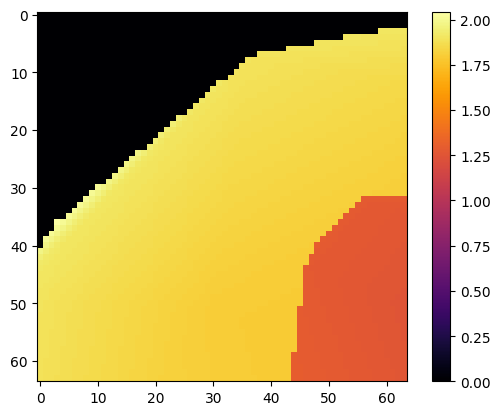

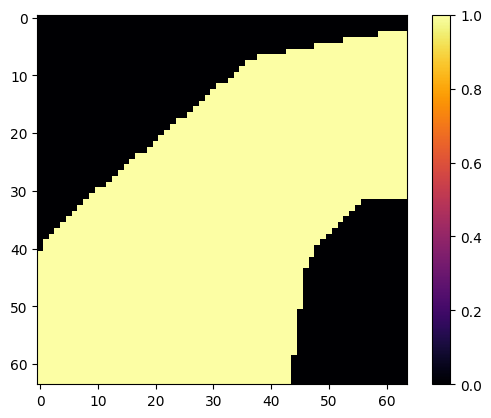

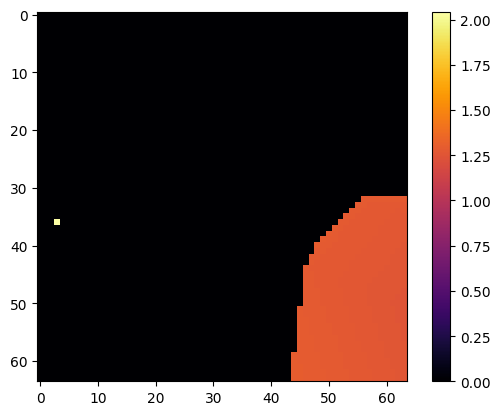

100%|██████████| 32/32 [00:02<00:00, 14.26it/s]


In [ ]:
for idx, data in enumerate(tqdm(test_loader)):
    if idx % 2 == 1:
        _, patches = data
    else:
        patches, _ = data

    # Separate patches
    patches = patches.unsqueeze(1)
    patch = patches[0]
    extracted = separate_depth(patch)

    if idx == 0:
        print(f"Batch {idx}: MSE: {loss:.4f}")
        print_depth_map(patch.squeeze(0))
        remainder_mask = (patch > 0) * (~(extracted > 0))
        remainder = remainder_mask * patch
        print_depth_map(extracted.detach().cpu().squeeze(0))
        print_depth_map(remainder.detach().cpu().squeeze(0))

  3%|▎         | 1/32 [00:00<00:29,  1.05it/s]

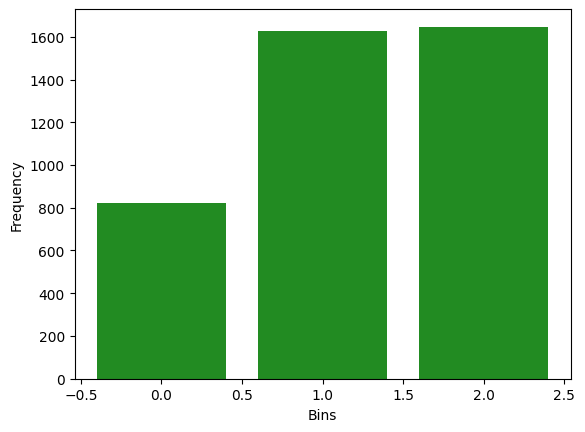

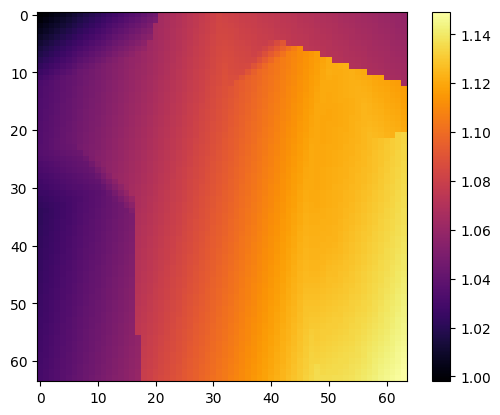

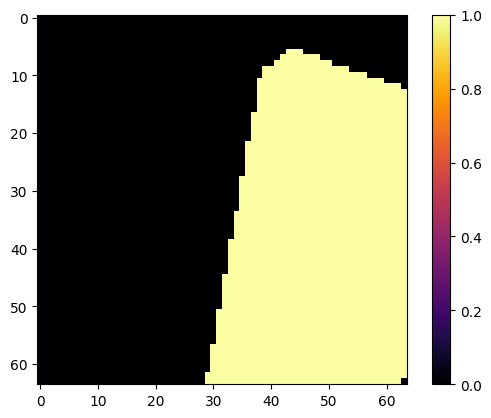

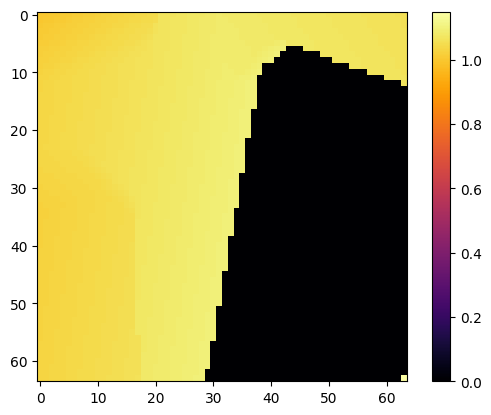

  9%|▉         | 3/32 [00:02<00:21,  1.37it/s]


In [30]:
for idx, data in enumerate(tqdm(test_loader)):
    if idx % 2 == 1:
        _, patches = data
    else:
        patches, _ = data

    # Separate patches
    patches = patches.unsqueeze(1)
    patch = patches[0]
    

    if idx == 2:
        extracted = separate_depth(patch)
        print_depth_map(patch.squeeze(0))
        remainder_mask = (patch > 0) * (~(extracted > 0))
        remainder = remainder_mask * patch
        print_depth_map(extracted.detach().cpu().squeeze(0))
        print_depth_map(remainder.detach().cpu().squeeze(0))
    if idx > 2: break

# Save model

In [ ]:
torch.save(model.state_dict(), SEGMENTATION_MODEL_NAME)

In [ ]:
model.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[-0.0293,  0.2764,  0.1253],
                        [ 0.2758,  0.0661, -0.2095],
                        [ 0.1213, -0.2530, -0.2333]]],
              
              
                      [[[-0.3111, -0.2827,  0.3220],
                        [-0.1668, -0.2172,  0.1801],
                        [ 0.0865,  0.1542,  0.1026]]],
              
              
                      [[[ 0.0023, -0.1470, -0.2997],
                        [ 0.3025,  0.2678, -0.0155],
                        [ 0.0161, -0.3036,  0.2065]]],
              
              
                      [[[ 0.3223, -0.0678, -0.3011],
                        [ 0.1045,  0.1977, -0.0463],
                        [ 0.2564, -0.0942, -0.1343]]],
              
              
                      [[[-0.3172, -0.1270, -0.0370],
                        [-0.3281,  0.2952,  0.2743],
                        [-0.0248,  0.2818, -0.0546]]],
              
              
               